In [1]:
# HTML("""
#     <head>
#         <title>Fernando de Vasconcelos</title>
#         <link rel="stylesheet" href="https://latex.now.sh/style.css">
#         <style type="text/css">
#             body {
#                 max-width: 65vw;
#             }
#             p {
#               font-size: 18px;
#             }
#         </style>
#     </head>
    
# """)

In [1]:
using Plots
using Random, Distributions
using Flux
using LinearAlgebra

In [2]:
gr();

Now we are going to plot the graph of the $sin(x)$ and $cos(x)$ functions.

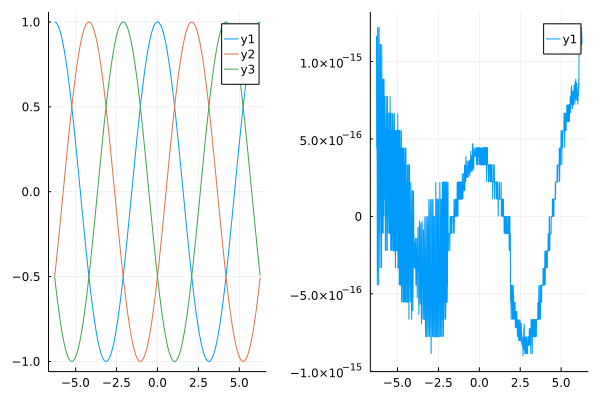

In [3]:
x = (-2*π):0.01:(2*π)
plot(x,cos.(x));
plot!(x,cos.(x .- 2*π/3))
p1 = plot!(x,cos.(x .+ 2*π/3));
y = cos.(x) .+ cos.(x .- 2*π/3) .+ cos.(x .+ 2*π/3)
p2 = plot(x,y);
plot(p1,p2, layout=(1,2))

Now we are going to analyze a curve fitting problem from a bayesian point of view. That is, with a regression problem, we are trying to find the probability distribution that generates our dataset with maximum likelihood and not just the "function" that rule our system. When we proceed like this, it is much more natural to infer an output $y \in \mathbb{R}^p$ given an input $x \in \mathbb{R}^N$.In more technical terms:

$$ p(y|x) = \dfrac{p(x|y)p(y)}{p(x)} $$

Let's generate data from a $sin$ function, add some noise to it and try to find the original function with a polynomial regression.

In [4]:
# Here we are going to set the fixed parameters or our problem
struct Dataset
    y_target::Array{Float64}
    x::Array{Float64}
end
MODEL_ORDER = 3
N_SAMPLES = 20 #Size of our dataset
std_dev = 0.25 #standard deviation of the noise
Ω = 1 #frequency of the sinus function to be used
Φ = π/3; #phase of the sinus function


In [5]:
#Random.seed!(123)
d = Normal(0,std_dev)
noise = rand(d, N_SAMPLES)
x = LinRange(0, 2*π, N_SAMPLES)[:,:]
y = sin.(Ω.*x .+ Φ) + noise
plot(LinRange(0, 2*π, 100), sin.(Ω.*LinRange(0, 2*π, 100) .+ Φ))
plot!(x, y, seriestype = :scatter)
dataset = Dataset(y,x)


Dataset([0.753558701650145; 1.1874538196159716; … ; 0.5982152849091457; 1.1320915951648214], [0.0; 0.3306939635357677; … ; 5.9524913436438185; 6.283185307179586])

In [6]:
function polyfit(order::Int32, dataset_::Dataset)
    # This function will do the polynomial regression algorithm in its "classical" form.
    # ----------------------------------------------------------------------------------
    # First, we are going to extract the data
    x = copy(dataset_.x)
    y = copy(dataset_.y_target)
    A = zeros(order + 1, order + 1)
    B = zeros(order + 1, 1)
    # Second, we calculate all the parameters of our linear system of equations.
    A = [sum(x.^(n + m - 2)) for n in 1:(order + 1), m in 1:(order + 1)]
    B = [sum(y .* (x.^(n - 1))) for n in 1:(order + 1)]
    # Third, we solve the resulting linear system Aw = B =>w = A^(-1) * B = A\B
    model_w = A\B
end
function normalization(x::Matrix{Float64}, norm_type::String)
    if norm_type == "-1,1"
        x_norm = 2 .* (x .- min(x...))./(max(x...)-min(x...)) .- 1
    elseif norm_type == "0,1"
        x_norm = x./(max(x...))
    end
end
P(x) = [x^i for i in 0:MODEL_ORDER]

P (generic function with 1 method)

  1.195761 seconds (2.87 M allocations: 158.767 MiB, 4.97% gc time, 99.68% compilation time)

[1.176420072332897, -0.06712431240886498, -0.3664505230460737, 0.06095824989589883]

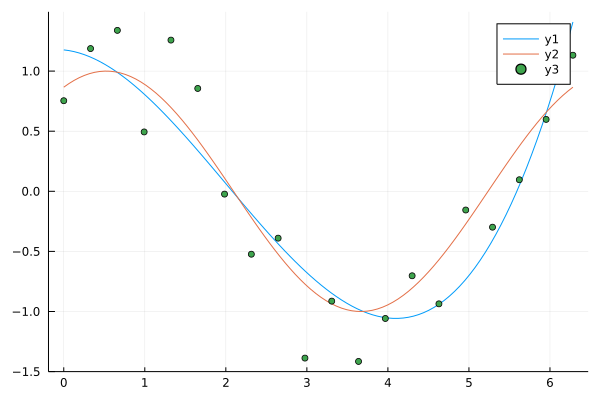

In [7]:
dataset_norm = Dataset(normalization(y,"-1,1"), normalization(x,"0,1"))
# plot(dataset.x,dataset.y_target, seriestype = :scatter)
# plot!(dataset_norm.x,dataset_norm.y_target, seriestype = :scatter)
@time model_w = polyfit(convert(Int32,MODEL_ORDER), dataset)
#model_w = polyfit(convert(Int32,MODEL_ORDER), dataset_norm)
print(model_w)
plot(LinRange(0, 2*π, 100), (model_w' * hcat(P.(LinRange(0, 2*π, 100))...))')
plot!(LinRange(0, 2*π, 100),sin.(Ω.*LinRange(0, 2*π, 100) .+ Φ))
plot!(dataset.x, dataset.y_target, seriestype = :scatter)
#plot(normalization(LinRange(0, 2*π, 100)[:,:], "0,1"), (model_w' * hcat(P.(LinRange(0, 1, 100))...))', label = "y_pred")
#plot!(normalization(LinRange(0, 2*π, 100)[:,:], "0,1"),sin.(Ω.*LinRange(0, 2*π, 100) .+ Φ))
#plot!(dataset_norm.x, dataset_norm.y_target, seriestype = :scatter)

In [8]:
A = [20 0 7.36 0; 0 7.36 0 4.87; 7.36 0 4.87 0; 0 4.87 0 3.81]
B = [sum(dataset_norm.y_target .* ((dataset_norm.x).^(n - 1))) for n in 1:(MODEL_ORDER + 1)]
w = inv(A)*B

4-element Vector{Float64}:
  0.12891158003181785
 -1.1924929675273739
 -0.2836976444562418
  1.5642266277469792

<a href="https://nando-ing.github.io/index.html"> My GitHub Page </a>

Now I'm gonna define a polynomial to fit the dataset we have:
$$ y(x,\vec{W}) = \sum_{i=0} ^ N w_i x^i $$

We could just define an error function in such a way we could obtain the best model as we get the error function lower. This is a naïve approach, since we would not be accounting for the noise among the dataset.

We are not interested in such an approach. We want to handle the uncertainty of our models correctly and that is why we should use probability.

For such an analysis, we will do the following assumption: We are dealing with a system which has a mathematical model that describes it, however our measures are all contaminated with noise, leading to a problem of mixed nature, at the same time deterministic and stochastic.

Generally in such cases, we assume that the noise in question is a gaussian white noise, because by the central limit theorem, its the limit case when we have an infinite number of random experiments being accumulated one over another. Infinite in this case must sound too "large", but in fact, the gaussian white noise would already well approximate 10 random experiments.

Sometimes the noise is not gaussian, but in this case, we have to study what type of noise affects our system. Usually, we use an extremely useful result that decomposes every probability distribution with a series of gaussian distributions. I will not enter in further details about this case.

Adopting the gaussian distribution as the origin of noise, we can start our analysis using probability theory. We will find candidates of probability distributions that gave origin to our dataset, after we will pick the most probable distribution that fits our criterion using a maximum likelihood estimation.

1. Finding candidates of probability distributions

For now, we will assume that our model is a third degree polynomial: $ y(x,\vec{W}) = w_0 + w_1x + w_2x^2 + w_3x^3 $. Then we have the probability density function to the origin of this dataset is:

$$ p(\textbf{t}|\vec{W},\textbf{x},\beta) = \prod_{i = 1}^{N_{SAMPLES}} p(y = t_i|\vec{W},x = x_i,\beta) = \prod_{i = 1}^{N_{SAMPLES}}\mathcal{N}(t_i|y(x,\vec{W}),\beta)) $$

Where $\vec{W} = (w_0,w_1,...,w_3)$.

Minimizing this expression is equivalent to minimize its logarithm, since the $log$ is a monotonic function, applying it, we have:
$$ log(p(\textbf{t}|\vec{W},\textbf{x},\beta)) = log(\prod_{i = 1}^{N_{SAMPLES}} \mathcal{N}(t_i|y(x,\vec{W}),\beta)) =  \sum_{i = 1}^{N_{SAMPLES}} log(\mathcal{N}(t_i|y(x,\vec{W}),\beta)) $$

Since, $\mathcal{N}(t_i|y(x,\vec{W}),\beta)) = \dfrac{\beta}{\sqrt{2\pi}}exp(-\dfrac{1}{2} (t_i - y(x,\vec{W}))^2\beta^2)$

We have:

$$ log(p(\textbf{t}|\vec{W},\textbf{x},\beta)) = \sum_{i = 1}^{N_{SAMPLES}} log(\mathcal{N}(t_i|y(x,\vec{W}),\beta)) =  \sum_{i = 1}^{N_{SAMPLES}} (log(\dfrac{1}{\beta \sqrt{2\pi}}) -\dfrac{1}{2} \dfrac{(t_i - y(x,\vec{W}))^2}{\beta^2})) = $$

$$ = -\dfrac{\beta}{2}\sum_{i = 1}^{N_{SAMPLES}} (t_i - y(x,\vec{W}))^2 + N_{SAMPLES} log(\dfrac{\beta}{\sqrt{2\pi}})$$

Which is equivalent to optimizing just:

$$ -\dfrac{1}{2}\sum_{i = 1}^{N_{SAMPLES}} (t_i - y(x,\vec{W}))^2 $$


Then the MLE will be the $\vec{W}_{ML}$ that minimizes the expression above.

Now we should reflect, why did we think in all this stuff to arrive with the same result we did before? In fact, now we can optimize to find also the $\sigma_{ML} = \dfrac{1}{\beta_{ML}} = \dfrac{1}{N_{SAMPLES}}\sum_{i = 1}^{N_{SAMPLES}} (t_i - y(x,\vec{W}))^2$ allowing us to find the probability distribution describing our model and consequently allowing us to build confidence intervals for the new inputs we would have in our model, instead of a single point estimation.

Now we are going to put this in practice using the Gradient Descent optimizer:

In [9]:
cost(w::Matrix{Float64}) = (1/N_SAMPLES)* norm(dataset.y_target - (w' * hcat(P.(x)...))')^2
#cost(w::Matrix{Float64}) = (1/N_SAMPLES).*(dataset.y_target - (w' * hcat(P.(x)...))')' * (dataset.y_target - (w' * hcat(P.(x)...))')
#cost(w::Vector{Float64}) = Float64(sum((dataset.y_target - (w' * hcat(P.(x)...))')' * (dataset.y_target - (w' * hcat(P.(x)...))')))
function training_loop(w0, dataset::Dataset, epochs::Int32, η::Float64, epoch_updt::Int32)
    #w = copy(model.w)
    w = w0[:,:]
    println("w: $w")
    y = dataset.y_target
    x = dataset.x
    dcost(w) = Flux.gradient(cost,w)[1]
    for epoch = 1:epochs
        dw = dcost(w)
        if epoch%epoch_updt == 0
            #if η < 0.01
            #    η = 1.414*η
            #end
            println("-------------------------------------- epoch:$epoch ----------------------------------------")
            println("w_old: $w")
            println("dw: $((dw'))")
            println("η dw: $(η.*(dw'))")
        end
        w -= η.*(dw)
        if epoch%epoch_updt == 0
            println("w: $w")
        end
        y_pred = w' * hcat(P.(x)...)
        cost(w)
        if epoch%epoch_updt == 0
            println("____________________________________________________________________________________________")
        end
    end
    w
end

training_loop (generic function with 1 method)

In [10]:
w = rand(MODEL_ORDER + 1)
wold = w
#model = Model(w)

#(w' * hcat(P.(x)...))'
#cost(w) = (dataset.y_target - (w' * hcat(P.(x)...))')' * (dataset.y_target - (w' * hcat(P.(x)...))')
#y_pred = (w' * hcat(P.(x)...))'
#cost(w)
#plot(x,y_pred)
w = training_loop(w, dataset, convert(Int32, 50000), 0.000096, convert(Int32, 5000))

w: [0.38180015965591063; 0.6855919411069165; 0.024298704907209423; 0.35610381548113335]


-------------------------------------- epoch:5000 ----------------------------------------
w_old: [0.41798721190149823; 0.5052845239273921; -0.49233131778602807; 0.069410134252897]
dw: [-0.21713347769619498 -0.050466830734524765 0.06589607211402582 -0.008813073813521477]
η dw: [-2.0844813858834718e-5 -4.844815750514377e-6 6.326022922946479e-6 -8.460550860980618e-7]
w: [0.41800805671535707; 0.5052893687431426; -0.492337643808951; 0.0694109803079831]


____________________________________________________________________________________________
-------------------------------------- epoch:10000 ----------------------------------------
w_old: [0.5094091118354626; 0.5236365916460274; -0.5186160562268216; 0.07295400807788696]
dw: [-0.16630928101446157 -0.027171716153841036 0.044848995836090255 -0.006119054067614371]
η dw: [-1.596569097738831e-5 -2.6084847507687396e-6 4.305503600264665e-6 -5.874291904909797e-7]
w: [0.50942507752644; 0.5236392001307781; -0.5186203617304219; 0.07295459550707745]
____________________________________________________________________________________________


-------------------------------------- epoch:15000 ----------------------------------------
w_old: [0.5797585216106638; 0.5323964715958749; -0.5362900686348919; 0.07539963936718061]
dw: [-0.12868908723726497 -0.010241175441506573 0.029586579676565528 -0.004171785279307727]
η dw: [-1.2354152374777437e-5 -9.83152842384631e-7 2.8403116489502905e-6 -4.004913868135418e-7]
w: [0.5797708757630385; 0.5323974547487172; -0.5362929089465409; 0.07540003985856743]
____________________________________________________________________________________________


-------------------------------------- epoch:20000 ----------------------------------------
w_old: [0.6345090954611357; 0.5342257420358348; -0.5476781299670449; 0.07704252718113966]
dw: [-0.10081995772865651 0.0019480820228421902 0.018447619924230718 -0.0027476728286028873]
η dw: [-9.678715941951026e-6 1.8701587419285027e-7 1.770971512726149e-6 -2.637765915458772e-7]
w: [0.6345187741770776; 0.5342255550199606; -0.5476799009385577; 0.0770427909577312]
____________________________________________________________________________________________


-------------------------------------- epoch:25000 ----------------------------------------
w_old: [0.6776937174838835; 0.5310827669614105; -0.5544844218349836; 0.07809890690954992]
dw: [-0.08013382186062842 0.010654814394502998 0.010341364324382818 -0.0017084097636423934]
η dw: [-7.69284689862033e-6 1.0228621818722878e-6 9.927709751407505e-7 -1.6400733730966977e-7]
w: [0.6777014103307821; 0.5310817440992287; -0.5544854146059587; 0.07809907091688723]
____________________________________________________________________________________________


-------------------------------------- epoch:30000 ----------------------------------------
w_old: [0.7122834527806263; 0.5244055235399617; -0.5579621684800292; 0.07872783224859041]
dw: [-0.06474010381447023 0.016805418554530327 0.004464954324124859 -0.0009521918725727829]
η dw: [-6.2150499661891424e-6 1.6133201812349114e-6 4.286356151159865e-7 -9.141041976698716e-8]
w: [0.7122896678305926; 0.5244039102197805; -0.5579625971156443; 0.07872792365901017]
____________________________________________________________________________________________


-------------------------------------- epoch:35000 ----------------------------------------
w_old: [0.7404676628476929; 0.5152490178909781; -0.5590326662769741; 0.07904626716250464]
dw: [-0.05324695724445393 0.02108163468257354 0.00022745424749293086 -0.0004040850333613122]
η dw: [-5.1117078954675775e-6 2.02383692952706e-6 2.1835607759321364e-8 -3.879216320268597e-8]
w: [0.7404727745555885; 0.5152469940540486; -0.5590326881125819; 0.07904630595466784]
____________________________________________________________________________________________


-------------------------------------- epoch:40000 ----------------------------------------
w_old: [0.7638602091219419; 0.5043864383266077; -0.5583729039516752; 0.07914019542799283]
dw: [-0.044629669918284036 0.023985109396513632 -0.002806070597992205 -8.93483946740048e-6]
η dw: [-4.284448312155268e-6 2.302570502065309e-6 -2.693827774072517e-7 -8.57744588870446e-10]
w: [0.763864493570254; 0.5043841357561056; -0.5583726345688977; 0.07914019628573742]
____________________________________________________________________________________________


-------------------------------------- epoch:45000 ----------------------------------------
w_old: [0.7836512476361002; 0.4923836146298466; -0.5564800615829284; 0.07907279862202783]
dw: [-0.03813379215694862 0.025884922531501015 -0.004955719714136109 0.000273852848359013]
η dw: [-3.6608440470670676e-6 2.4849525630240976e-6 -4.7574909255706646e-7 2.628987344246525e-8]
w: [0.7836549084801472; 0.4923811296772836; -0.5564795858338358; 0.07907277233215439]
____________________________________________________________________________________________


-------------------------------------- epoch:50000 ----------------------------------------
w_old: [0.8007189715403391; 0.47965382715125415; -0.5537189893826906; 0.07889047610197102]
dw: [-0.03320382655098083 0.027052572925784335 -0.006457060783197077 0.00047415408667816905]
η dw: [-3.1875673488941597e-6 2.5970470008752964e-6 -6.198778351869195e-7 4.5518792321104233e-8]
w: [0.800722159107688; 0.47965123010425326; -0.5537183695048554; 0.0788904305831787]
____________________________________________________________________________________________


4×1 Matrix{Float64}:
  0.800722159107688
  0.47965123010425326
 -0.5537183695048554
  0.0788904305831787

Investigate the divergence when $\eta = 1$, since the $dw$ when $\eta = 0.000096$ is really low.

x: [0.0; 0.3306939635357677; 0.6613879270715354; 0.992081890607303; 1.3227758541430708; 1.6534698176788385; 1.984163781214606; 2.3148577447503738; 2.6455517082861415; 2.9762456718219092; 3.306939635357677; 3.6376335988934447; 3.968327562429212; 4.29902152596498; 4.6297154895007475; 4.960409453036515; 5.291103416572283; 5.621797380108051; 5.9524913436438185; 6.283185307179586]


y_pred: [0.800722159107688; 0.901639125482475; 0.8985665274689679; 0.8086224185543109; 0.6489248522256482; 0.4365918819701235; 0.1887415612748813; -0.07750805637293501; -0.34503891748618076; -0.5967329685777116; -0.8154721561603839; -0.9841384267470543; -1.0856137268505766; -1.1027800029838097; -1.0185192016596067; -0.8157132693908284; -0.4772441526903215; 0.014006201929049666; 0.675155847954434; 1.5233228388729714]


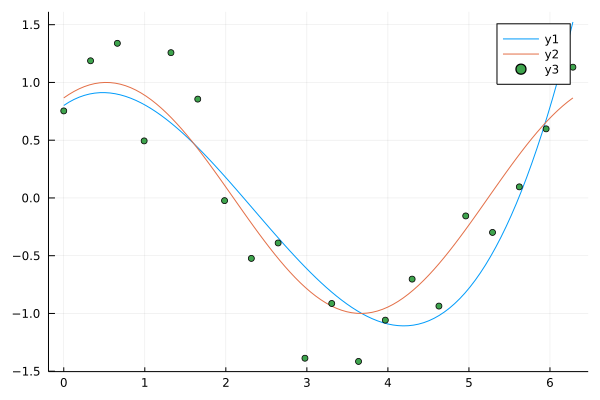

In [11]:
y_pred = (w' * hcat(P.(x)...))'
println("x: $x")
println("y_pred: $y_pred")
plot(LinRange(0, 2*π, 100), (w' * hcat(P.(LinRange(0, 2*π, 100))...))')
plot!(LinRange(0, 2*π, 100),sin.(Ω.*LinRange(0, 2*π, 100) .+ Φ))
plot!(x, y, seriestype = :scatter)
#plot(normalization(LinRange(0, 2*π, 100)[:,:]), (w' * hcat(P.(LinRange(0, 1, 100))...))')
#plot!(normalization(LinRange(0, 2*π, 100)[:,:]),sin.(Ω.*LinRange(0, 2*π, 100) .+ Φ))
#plot!(dataset_norm.x, dataset_norm.y_target, seriestype = :scatter)